# Correlation Analysis (All Areas)

This document includes Python codes that conduct correlation analysis between water quality parameters and water depth.

The analysis is conducted in all managed areas in Florida

* [1.Data Preprocess](#preprocessing)    
* [2.Correlation Analysis](#correlation)
	* [2.1.Result of Correlation Analysis](#result_cor)
		* [2.1.1.Water Depth](#result_cor_wd)
		* [2.1.2 Land development index (LDI_HUC_LSS)](#result_cor_ldi_huc_lss)
		* [2.1.3 Land development index (LDI_HUC_LSS)](#result_cor_ldi_huc_med)
		* [2.1.4 Land development index (LDI_HUC_LSS)](#result_cor_ldi_who_lss)
		* [2.1.5 Land development index (LDI_HUC_LSS)](#result_cor_ldi_who_med)
* [3.Correlation Analysis](#reg_analysis)
	* [3.1.Result of Correlation Analysis](#result_reg)
		* [3.1.1.Water Depth](#result_reg_wd)
		* [3.1.2 Land development index (LDI_HUC_LSS)](#result_reg_ldi_huc_lss)
		* [3.1.3 Land development index (LDI_HUC_LSS)](#result_reg_ldi_huc_med)		
		* [3.1.4 Land development index (LDI_HUC_LSS)](#result_cor_ldi_who_lss)
		* [3.1.5 Land development index (LDI_HUC_LSS)](#result_cor_ldi_who_med)


In [11]:
import geopandas as gpd
import rasterio as rio
from scipy.stats import pearsonr
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt


# 1. Data Preprocessing <a class="anchor" id="preprocessing"></a>
Define the water depth, water quality parameter, and LDI folders

In [12]:
path_gis = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/'
#path_LDI = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/LDI/'
path_LDI = 'E:\Projects\SEACAR_WQ_Pilot\GIS_data\covariates\LDI/'
WQPara_folder = "E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/"
WaterDepth = 'E:\Projects\SEACAR_WQ_Pilot\GIS_data\covariates/NCEI_DEM_30m.tif'
LDI_HUC_LSS = path_LDI + 'LDI_HUC12River_LogScaleSUM.tif'
LDI_HUC_Median = path_LDI +'LDI_HUC12River_Median.tif'
LDI_WHO_LSS = path_LDI + 'LDI_WholeRiver_LogScaleSUM.tif'
LDI_WHO_Median = path_LDI + 'LDI_WholeRiver_Median.tif'

Extract values from covariates rasters to observation points

In [13]:
def extract_raster_values(shapefile_path, raster_path, column_name):
    gdf = gpd.read_file(shapefile_path)
    parameter_name = gdf.iloc[0]['ParameterN']
    with rio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)
        raster_data = src.read(1)
        transform = src.transform
        row_index, col_index = rio.transform.rowcol(transform, gdf['geometry'].x, gdf['geometry'].y)
        gdf[column_name] = raster_data[row_index, col_index]
        gdf = gdf.rename(columns={"ResultValu": parameter_name})
    return gdf

Function to catch specific exceptions of file name

In [14]:
def parse_file_name(file_name):
    # Define regular expression pattern of the file name
    pattern = r"(.*)_(\w+)_(\d+)_(\d+)"
    try:
        parameter, season, year_from, year_to = re.search(pattern, file_name).groups()
        return f"{year_from}-{year_to}", season
    except AttributeError:
        return None, None

Function to add year and season to csv file

In [15]:
def add_year_season_to_gdf(gdf, shapefile_path):
    year, season = parse_file_name(Path(shapefile_path).stem)
    if year and season:
        gdf["Year"] = f"{year}"
        gdf["Season"] = season
    return gdf

Function to ensure no csv files exists in the folder

In [16]:
def remove_csv_files(dir_name):
    for item in os.listdir(dir_name):
        if item.endswith(".csv"):
            os.remove(os.path.join(dir_name, item))
            
def remove_result_files(dir_name):
    for item in os.listdir(dir_name):
        if item.startswith("regression_result"):
            os.remove(os.path.join(dir_name, item))

Function to generate all csv files with water depth values and LDI

In [ ]:
def generate_csv_files(shapefile_folder, raster_path, column_name):
    for file in os.listdir(shapefile_folder):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(shapefile_folder, file)
            output_csv_path = shapefile_path.replace(".shp", ".csv")

            if os.path.exists(output_csv_path):
                gdf_existing = pd.read_csv(output_csv_path)
                if column_name in gdf_existing.columns:
                    print(f"Column '{column_name}' already exists in {output_csv_path}")
                    continue
                gdf = extract_raster_values(shapefile_path, raster_path, column_name)
                gdf_existing[column_name] = gdf[column_name]
                gdf_existing.to_csv(output_csv_path, index=False)
                print(f"Appended {column_name} to {output_csv_path}")
            else:
                gdf = extract_raster_values(shapefile_path, raster_path, column_name)
                add_year_season_to_gdf(gdf, shapefile_path)
                gdf.to_csv(output_csv_path, index=False)
                print(f"Created {output_csv_path}")

In [18]:
remove_csv_files(WQPara_folder)

Export extracted values to csv files

In [19]:
# All shapefile in the folder will generate to csv file with water depth values
column_name = 'Water_Depth'
generate_csv_files(WQPara_folder, WaterDepth, column_name)

# Append LDI to the csv file
column_LDI_HUC_LSS = 'LDI_HUC_LSS'
generate_csv_files(WQPara_folder,LDI_HUC_LSS, column_LDI_HUC_LSS)

column_LDI_HUC_Median = 'LDI_HUC_Median'
generate_csv_files(WQPara_folder,LDI_HUC_Median, column_LDI_HUC_Median)

column_LDI_WHO_LSS = 'LDI_WHO_LSS'
generate_csv_files(WQPara_folder,LDI_WHO_LSS, column_LDI_WHO_LSS)

column_LDI_WHO_Median = 'LDI_WHO_Median'
generate_csv_files(WQPara_folder,LDI_WHO_Median, column_LDI_WHO_Median)

Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Dry_2016_2018_Big_Bend.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Big_Bend.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Big_Bend.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Created E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Wet_2016_2018_Big_Bend.csv
Created E:\Projects\SEACAR_WQ_

Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Wet_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/SA_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:\Projects\SEACAR_WQ_Pilot\Correlation_A

# 2. Pearson correlation <a class="anchor" id="correlation"></a>
Define a funtion to calculate Pearson correlation

In [20]:
def calculate_pearson_correlation(csv_path, variable_name):
    df = pd.read_csv(csv_path)
    paraName = df.columns[4]  # the specific parameter name is in the 5rd column
    column1 = df.loc[:, variable_name] # dependent variable
    column2 = df.loc[:, paraName] # independent variable
    corr, p_value = pearsonr(column1, column2)

    return corr, p_value, column2, column1

Function to check the p-values

In [21]:
def check_p_value(p_value):
    if float(p_value) < 0.01:
        return "{:.3f} **".format(float(p_value))
    elif float(p_value) < 0.05:
        return "{:.3f} *".format(float(p_value))
    else:
        return "{:.3f}".format(float(p_value))

Function to orgarnize the Pearson correlation results to dataframe

In [22]:
def print_pearson_result(csv_folder, variable_name, out_path):
    results = []
    all_output_ls = []
    for file in sorted(os.listdir(csv_folder)):
        if file.endswith(".csv"):
            csv_path = os.path.join(csv_folder, file)
            corr, p_value, d_var, ind_var = calculate_pearson_correlation(csv_path,variable_name)
            df = pd.read_csv(csv_path)
            dependent = df.columns[4] # the specific parameter name is in the 5rd column
            independent = df[variable_name].name
            year = df.iloc[0, 7]
            season = df.iloc[0, 8]
            p_value_str = check_p_value(p_value)
            results.append((dependent, independent, year, season, corr, p_value_str))
            all_output_ls.append([dependent, independent, year, season, corr, p_value_str,list(ind_var),list(d_var)])
            # Create plots with regression line

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Dependent', 'Independent', 'Year', 'Season', 'Pearson correlation coefficient', 'p-value'])
    all_output_df = pd.DataFrame(all_output_ls, columns=['Dependent', 'Independent', 'Year', 'Season', 'Pearson correlation coefficient', 'p-value','ind_values','d_values'])
    # Generate output path
    # Write the results to an Excel file
    results_df.to_excel(output_path, index=False)
    print(f"Pearson results written to {output_path}")
    return results_df, all_output_df

Export the regression result in xlsx files

In [24]:
# First remove result files before generate them
remove_result_files(WQPara_folder)

csv_folder = WQPara_folder

# Write the results to an Excel file of the water depth
variable_name = 'Water_Depth'
output_path = os.path.join(csv_folder, f"pearson_results_{variable_name}.xlsx")
results_WD, output_WD = print_pearson_result(csv_folder,variable_name, output_path)

# Write the results to an Excel file of the LDI_HUC_LSS
variable_name = 'LDI_HUC_LSS'
output_path = os.path.join(csv_folder, f"pearson_results_{variable_name}.xlsx")
results_LDI_HUC_LSS, output_LDI_HUC_LSS = print_pearson_result(csv_folder,variable_name, output_path)

# Write the results to an Excel file of the LDI_HUC_Median
variable_name = 'LDI_HUC_Median'
output_path = os.path.join(csv_folder, f"pearson_results_{variable_name}.xlsx")
results_LDI_HUC_Median, output_LDI_HUC_Median = print_pearson_result(csv_folder,variable_name, output_path)

# Write the results to an Excel file of the LDI_WHO_LSS
variable_name = 'LDI_WHO_LSS'
output_path = os.path.join(csv_folder, f"pearson_results_{variable_name}.xlsx")
results_LDI_WHO_LSS, output_LDI_WHO_LSS = print_pearson_result(csv_folder,variable_name, output_path)

# Write the results to an Excel file of the LDI_WHO_Median
variable_name = 'LDI_WHO_Median'
output_path = os.path.join(csv_folder, f"pearson_results_{variable_name}.xlsx")
print_pearson_result(csv_folder,variable_name, output_path)
results_LDI_WHO_Median, output_LDI_WHO_Median = print_pearson_result(csv_folder,variable_name, output_path)

Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_Water_Depth.xlsx
Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_LDI_HUC_LSS.xlsx
Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_LDI_HUC_Median.xlsx
Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_LDI_WHO_LSS.xlsx
Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_LDI_WHO_Median.xlsx
Pearson results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/pearson_results_LDI_WHO_Median.xlsx


## 2.1 Results of Correlation Analysis <a class="anchor" id="result_correlation"></a>
### 2.1.1. Water depth <a class="anchor" id="result_cor_wd"></a>

In [25]:
results_WD

,Dependent,Independent,Year,Season,Pearson correlation coefficient,p-value
0,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-0.101826,0.071
1,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-0.021911,0.801
2,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-0.157404,0.177
3,Dissolved Oxygen,Water_Depth,2016-2018,Wet,-0.249314,0.018 *
4,Dissolved Oxygen,Water_Depth,2016-2018,Wet,0.009560,0.974
5,Dissolved Oxygen,Water_Depth,2016-2018,Wet,-0.096130,0.516
6,Salinity,Water_Depth,2016-2018,Dry,-0.400857,0.000 **
7,Salinity,Water_Depth,2016-2018,Dry,-0.473043,0.000 **
8,Salinity,Water_Depth,2016-2018,Dry,-0.481034,0.043 *
9,Salinity,Water_Depth,2016-2018,Wet,0.071471,0.491


### 2.1.2  Land development index (LDI_HUC_LSS) <a class="anchor" id="result_cor_ldi_huc_lss"></a>

In [26]:
results_LDI_HUC_LSS

,Dependent,Independent,Year,Season,Pearson correlation coefficient,p-value
0,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.284920,0.000 **
1,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.390079,0.000 **
2,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.286533,0.013 *
3,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.252156,0.017 *
4,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.269826,0.351
5,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.547451,0.000 **
6,Salinity,LDI_HUC_LSS,2016-2018,Dry,-0.689531,0.000 **
7,Salinity,LDI_HUC_LSS,2016-2018,Dry,-0.539753,0.000 **
8,Salinity,LDI_HUC_LSS,2016-2018,Dry,-0.340555,0.167
9,Salinity,LDI_HUC_LSS,2016-2018,Wet,-0.685906,0.000 **


### 2.1.3. Land development index (LDI_HUC_Median) <a class="anchor" id="result_cor_ldi_huc_med"></a>

In [27]:
results_LDI_HUC_Median

,Dependent,Independent,Year,Season,Pearson correlation coefficient,p-value
0,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,0.094820,0.093
1,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,-0.203239,0.018 *
2,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,-0.261989,0.023 *
3,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.118340,0.267
4,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.487076,0.077
5,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.235079,0.108
6,Salinity,LDI_HUC_Median,2016-2018,Dry,0.105287,0.062
7,Salinity,LDI_HUC_Median,2016-2018,Dry,-0.196545,0.029 *
8,Salinity,LDI_HUC_Median,2016-2018,Dry,-0.006903,0.978
9,Salinity,LDI_HUC_Median,2016-2018,Wet,0.154721,0.134


### 2.1.4 Land development index (LDI_WHO_LSS) <a class="anchor" id="result_cor_ldi_who_lss"></a>


In [28]:
results_LDI_WHO_LSS

,Dependent,Independent,Year,Season,Pearson correlation coefficient,p-value
0,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.294720,0.000 **
1,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.306406,0.000 **
2,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.237967,0.040 *
3,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.295112,0.005 **
4,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.309594,0.281
5,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.413519,0.003 **
6,Salinity,LDI_WHO_LSS,2016-2018,Dry,-0.783480,0.000 **
7,Salinity,LDI_WHO_LSS,2016-2018,Dry,-0.407988,0.000 **
8,Salinity,LDI_WHO_LSS,2016-2018,Dry,-0.217663,0.386
9,Salinity,LDI_WHO_LSS,2016-2018,Wet,-0.684079,0.000 **


### 2.1.5 Land development index (LDI_WHO_Median) <a class="anchor" id="result_cor_ldi_who_med"></a>


In [29]:
results_LDI_WHO_Median

,Dependent,Independent,Year,Season,Pearson correlation coefficient,p-value
0,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,0.088722,0.116
1,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,-0.274549,0.001 **
2,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,-0.266180,0.021 *
3,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.121207,0.255
4,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.239609,0.409
5,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.259121,0.075
6,Salinity,LDI_WHO_Median,2016-2018,Dry,0.104821,0.063
7,Salinity,LDI_WHO_Median,2016-2018,Dry,-0.004576,0.960
8,Salinity,LDI_WHO_Median,2016-2018,Dry,0.060880,0.810
9,Salinity,LDI_WHO_Median,2016-2018,Wet,0.155818,0.132


# 3. Regression analysis <a class="anchor" id="reg_analysis"></a>

Funtion to calculate linear regression

In [64]:
def ols_regression(csv_path, variable_name):
    df = pd.read_csv(csv_path)
    paraName = df.columns[4]  # the specific parameter name is in the 5rd column
    df.drop(df[df.loc[:, paraName] >1000].index,inplace=True) #remove outliers
    column1 = df.loc[:, variable_name]
    column2 = df.loc[:, paraName]
    X = sm.add_constant(column1)
    model = sm.OLS(column2, X).fit()
    # Only get the coefficient, p-values, and adjusted r square
    return model.params[1], model.pvalues[1], model.rsquared_adj, column1,column2

Function to organize coefficient, p-values, and adjusted R-square from linear regression results to dataframe

In [65]:
def print_regression_result(csv_folder, variable_name, outpath):
    results = []
    outputs = []
    for file in sorted(os.listdir(csv_folder)):
        if file.endswith(".csv"):
            csv_path = os.path.join(csv_folder, file)
            coeff, p_value, adj_rsq, ind_var, d_var = ols_regression(csv_path,variable_name)
            df = pd.read_csv(csv_path)
            dependent = df.columns[4] # the specific parameter name is in the 5rd column
            independent = df[variable_name].name
            year = df.iloc[0, 7]
            season = df.iloc[0, 8]
            p_value_str = check_p_value(p_value)
            results.append((dependent, independent, year, season, coeff, adj_rsq, p_value_str))
            outputs.append((dependent, independent, year, season, coeff, adj_rsq, p_value_str, ind_var, d_var))
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Dependent', 'Independent', 'Year', 'Season', 'Coefficient', 'Adjusted R-squared', 'p-value'])
    outputs_df = pd.DataFrame(outputs, columns=['Dependent', 'Independent', 'Year', 'Season', 'Coefficient', 'Adjusted R-squared', 'p-value','ind_values','d_values'])
    # Write the results to an Excel file
    results_df.to_excel(outpath, index=False)
    print(f"Regression results written to {outpath}")
    return results_df, outputs_df

Run OSL regressions for all covariates

In [66]:
# Calculated regression
csv_folder = WQPara_folder

variable_name = 'Water_Depth'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_WD, outputs_WD = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_HUC_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_HUC_LSS, outputs_LDI_HUC_LSS = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_HUC_Median'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_HUC_Median, outputs_LDI_HUC_Median = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_WHO_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_WHO_LSS, outputs_LDI_WHO_LSS = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_WHO_Median'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_WHO_Median, outputs_LDI_WHO_Median = print_regression_result(csv_folder,variable_name, output_path)


Regression results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/regression_results_Water_Depth.xlsx
Regression results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/regression_results_LDI_HUC_LSS.xlsx
Regression results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/regression_results_LDI_HUC_Median.xlsx
Regression results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/regression_results_LDI_WHO_LSS.xlsx
Regression results written to E:\Projects\SEACAR_WQ_Pilot\Correlation_Analysis\WQPara/regression_results_LDI_WHO_Median.xlsx


In [67]:
def plot_regression(output_df):
    ncol  = 4
    nrow = int(output_df.shape[0] / ncol) + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(16, 16))
    n = 0
    for index, row in output_df.iterrows():
        r, c  = int(n/ncol), n % ncol

        ind_var, d_var = np.array(row['ind_values']), np.array(row['d_values'])
        axes[r,c].plot(ind_var, d_var, 'o')
        m, b = np.polyfit(ind_var, d_var, 1)
        axes[r,c].plot(ind_var, m*ind_var+b, color = 'red')
        axes[r,c].set_title(' {} {} season \n R2 = {}, p = {}'.format(row['Year'], row['Season'], round(float(row['Adjusted R-squared']),3), row['p-value']))
        axes[r,c].set_xlabel(row['Dependent'])
        axes[r,c].set_ylabel(row['Independent'])
        plt.subplots_adjust(hspace=0.5)
        n = n+1


## 3.1 Results of Regression Analysis <a class="anchor" id="result_reg"></a>
### 3.1.1 Water depth <a class="anchor" id="result_reg_wd"></a>

In [68]:
results_WD

,Dependent,Independent,Year,Season,Coefficient,Adjusted R-squared,p-value
0,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-2.387829e-02,0.007207,0.071
1,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-6.259457e-03,-0.007035,0.801
2,Dissolved Oxygen,Water_Depth,2016-2018,Dry,-5.597656e-02,0.011417,0.177
3,Dissolved Oxygen,Water_Depth,2016-2018,Wet,-4.564853e-02,0.051500,0.018 *
4,Dissolved Oxygen,Water_Depth,2016-2018,Wet,1.672464e-03,-0.083234,0.974
5,Dissolved Oxygen,Water_Depth,2016-2018,Wet,-2.964366e-02,-0.012297,0.516
6,Salinity,Water_Depth,2016-2018,Dry,-7.388430e-01,0.158005,0.000 **
7,Salinity,Water_Depth,2016-2018,Dry,-5.359514e-01,0.217407,0.000 **
8,Salinity,Water_Depth,2016-2018,Dry,-6.443031e-01,0.183355,0.043 *
9,Salinity,Water_Depth,2016-2018,Wet,7.517647e-38,-4.952352,0.234


Scatter plots and regression lines

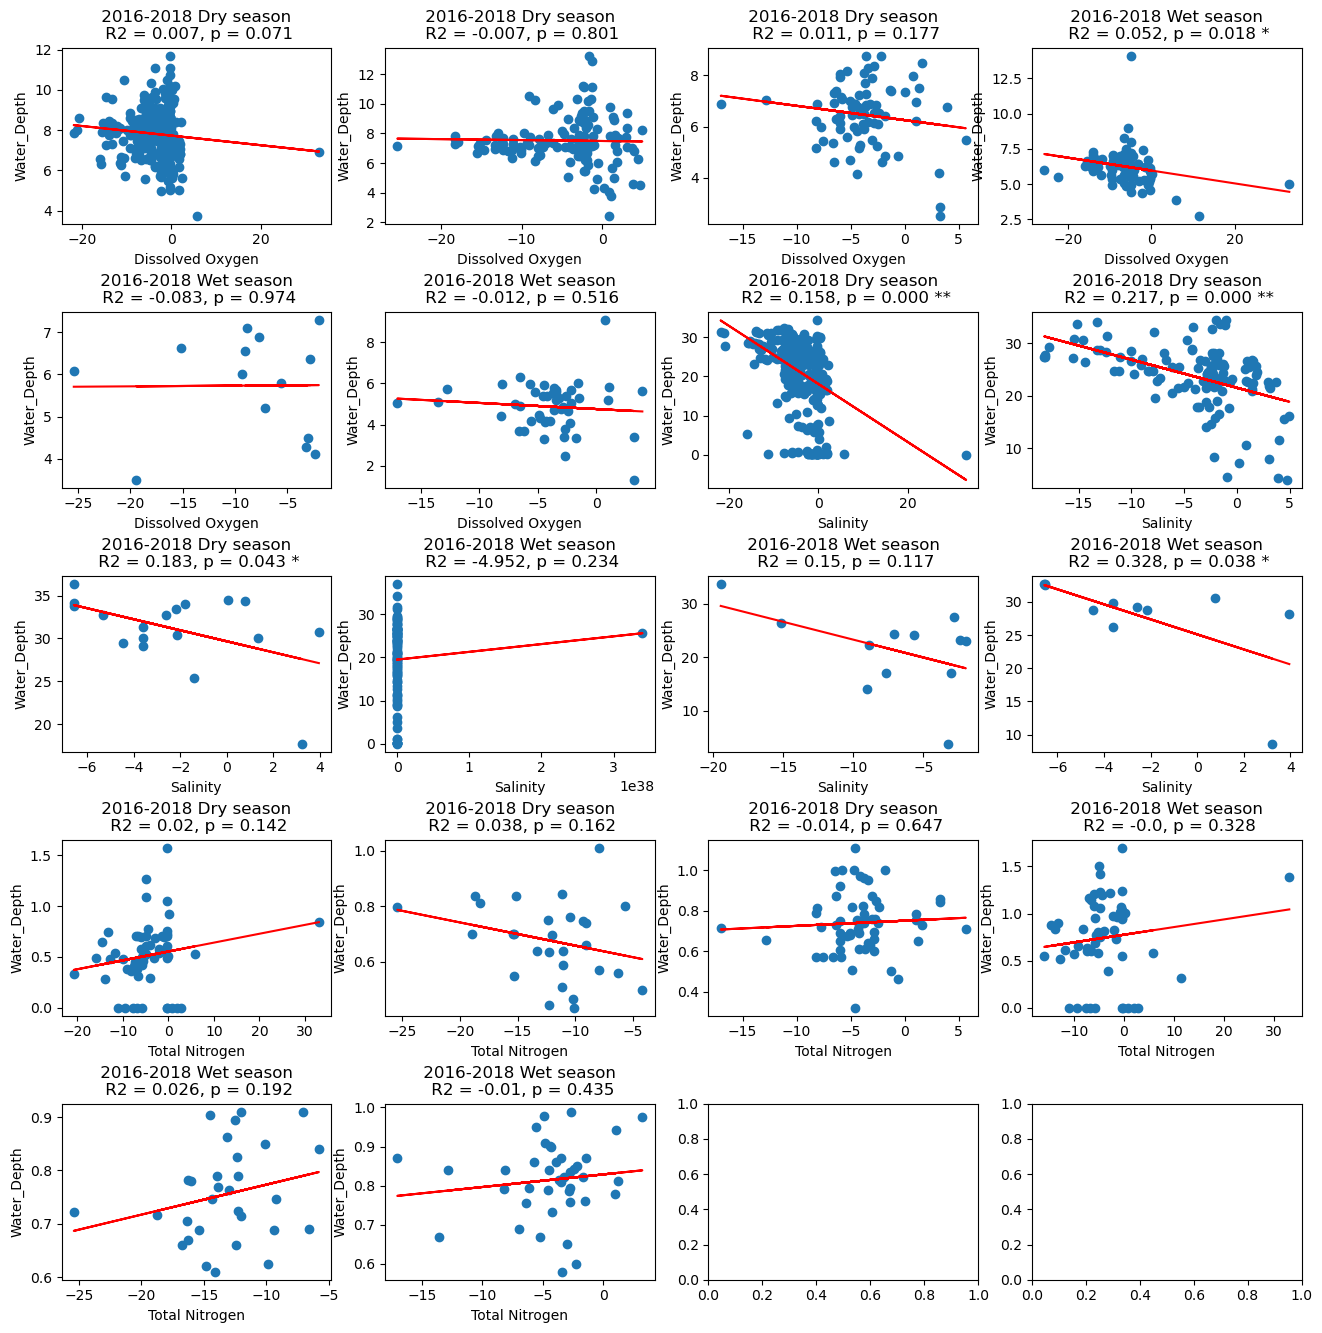

In [69]:
plot_regression(outputs_WD)

### 3.1.2 Land development index (LDI_HUC_LSS) <a class="anchor" id="result_reg_ldi_huc_lss"></a>

In [70]:
results_LDI_HUC_LSS

,Dependent,Independent,Year,Season,Coefficient,Adjusted R-squared,p-value
0,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.148074,0.078244,0.000 **
1,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.208872,0.145787,0.000 **
2,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Dry,-0.189719,0.069527,0.013 *
3,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.158683,0.052941,0.017 *
4,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.129781,-0.004460,0.351
5,Dissolved Oxygen,LDI_HUC_LSS,2016-2018,Wet,-0.293748,0.284479,0.000 **
6,Salinity,LDI_HUC_LSS,2016-2018,Dry,-2.816607,0.473777,0.000 **
7,Salinity,LDI_HUC_LSS,2016-2018,Dry,-1.069257,0.285525,0.000 **
8,Salinity,LDI_HUC_LSS,2016-2018,Dry,-0.694719,0.060727,0.167
9,Salinity,LDI_HUC_LSS,2016-2018,Wet,-3.119593,0.464773,0.000 **


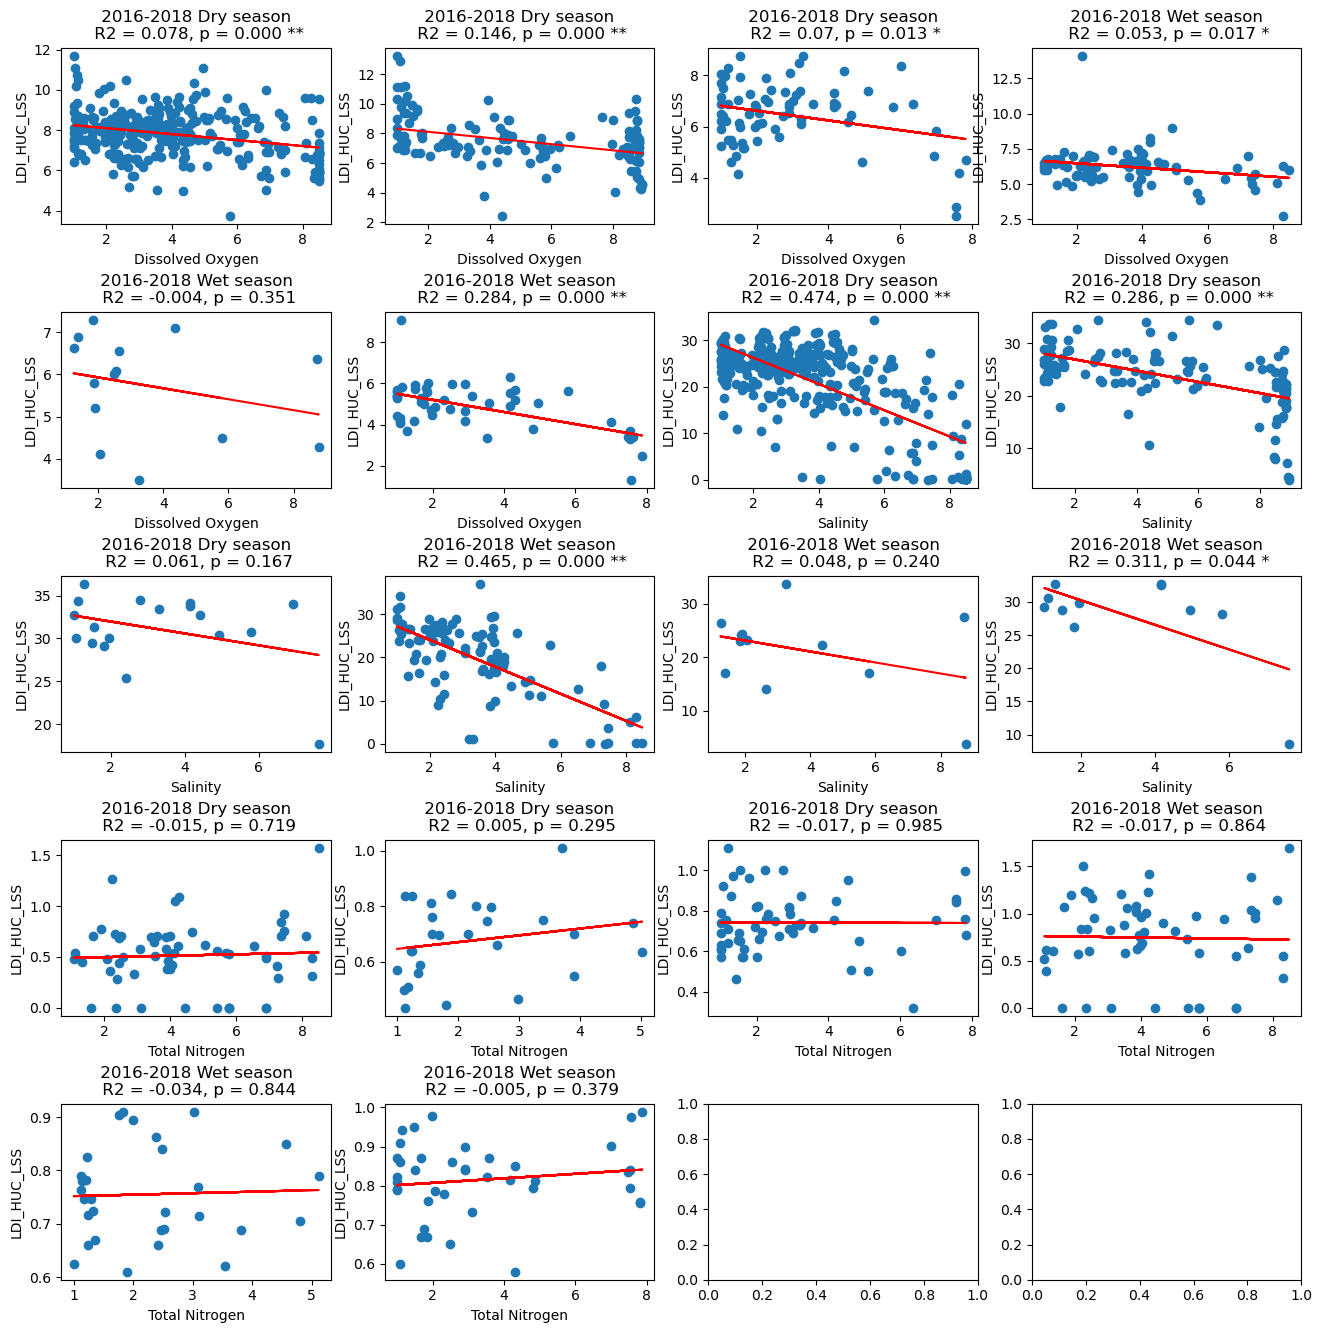

In [71]:
plot_regression(outputs_LDI_HUC_LSS)

### 3.1.3 Land development index (LDI_HUC_Median) <a class="anchor" id="result_reg_ldi_huc_med"></a>

In [72]:
results_LDI_HUC_Median

,Dependent,Independent,Year,Season,Coefficient,Adjusted R-squared,p-value
0,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,0.471393,0.005825,0.093
1,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,-0.183858,0.034098,0.018 *
2,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Dry,-0.234366,0.055880,0.023 *
3,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.500379,0.002800,0.267
4,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.356234,0.173680,0.077
5,Dissolved Oxygen,LDI_HUC_Median,2016-2018,Wet,-0.198807,0.034724,0.108
6,Salinity,LDI_HUC_Median,2016-2018,Dry,4.114106,0.007926,0.062
7,Salinity,LDI_HUC_Median,2016-2018,Dry,-0.644418,0.030750,0.029 *
8,Salinity,LDI_HUC_Median,2016-2018,Dry,-0.017356,-0.062449,0.978
9,Salinity,LDI_HUC_Median,2016-2018,Wet,4.719920,0.013443,0.134


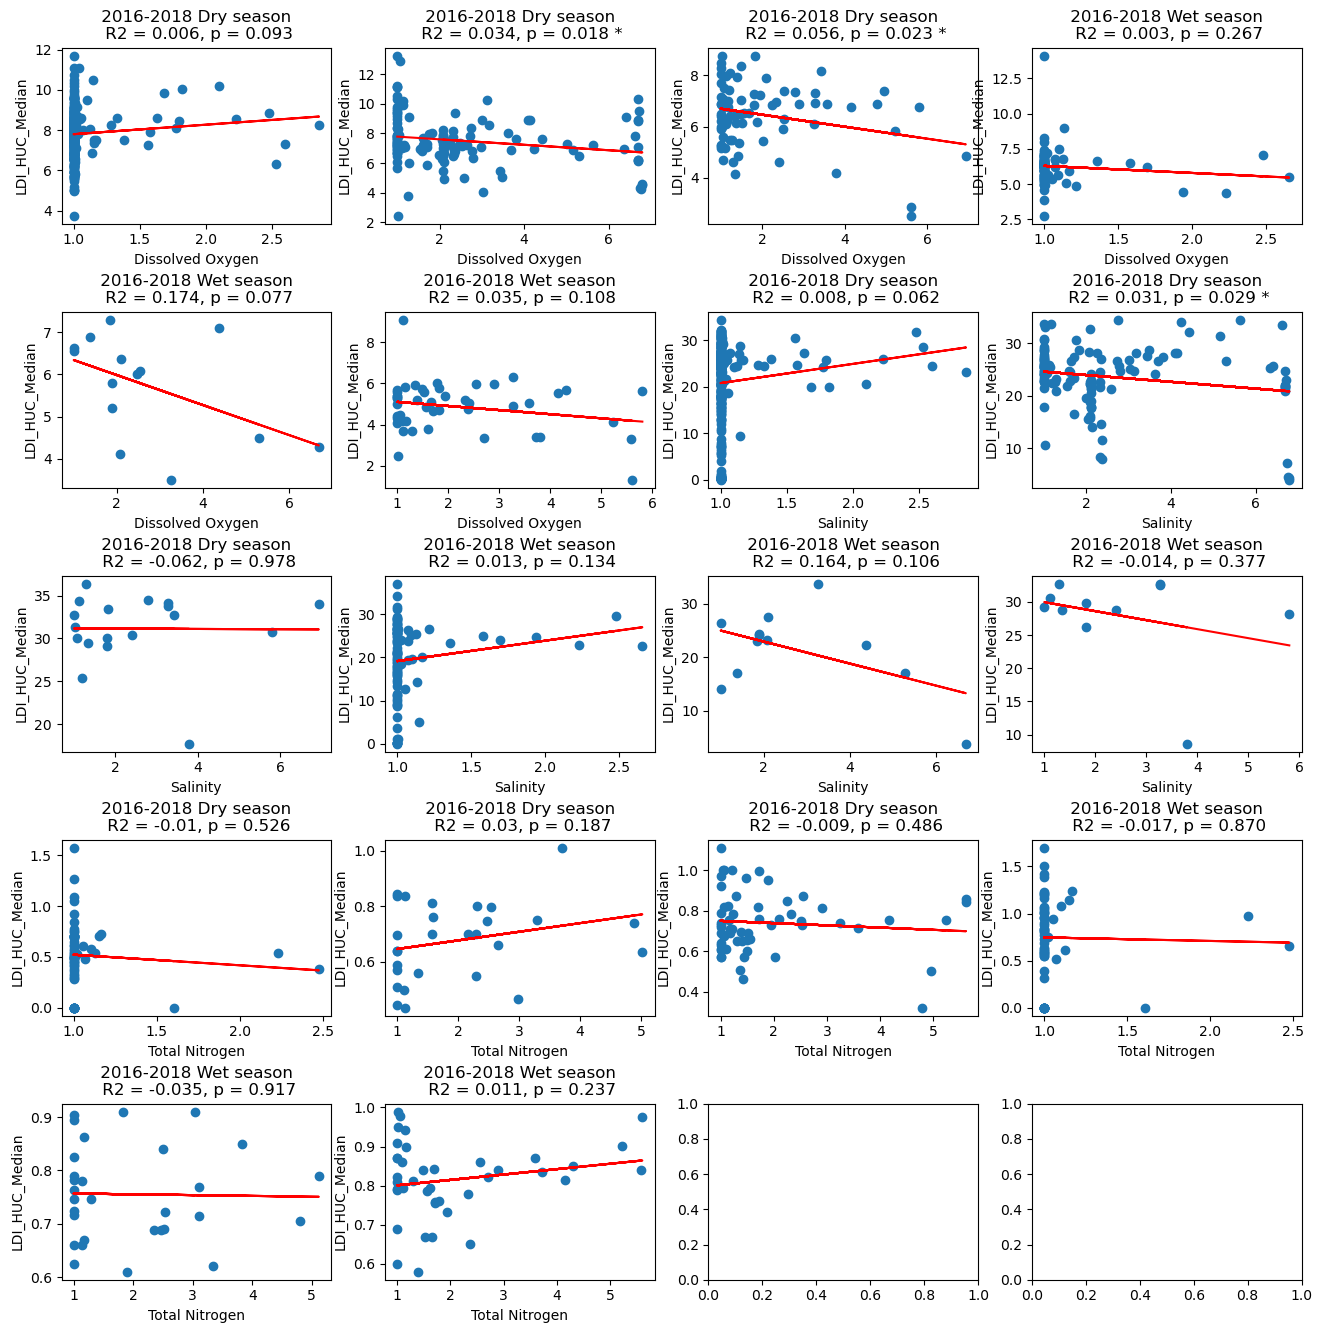

In [73]:
plot_regression(outputs_LDI_HUC_Median)

### 3.1.4 Land development index (LDI_WHO_LSS) <a class="anchor" id="result_cor_ldi_who_lss"></a>

In [74]:
results_LDI_WHO_LSS

,Dependent,Independent,Year,Season,Coefficient,Adjusted R-squared,p-value
0,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.157652,0.083943,0.000 **
1,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.186303,0.087071,0.000 **
2,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Dry,-0.231407,0.043705,0.040 *
3,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.215426,0.076717,0.005 **
4,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.162401,0.020503,0.281
5,Dissolved Oxygen,LDI_WHO_LSS,2016-2018,Wet,-0.363443,0.152976,0.003 **
6,Salinity,LDI_WHO_LSS,2016-2018,Dry,-3.294089,0.612608,0.000 **
7,Salinity,LDI_WHO_LSS,2016-2018,Dry,-0.907490,0.159622,0.000 **
8,Salinity,LDI_WHO_LSS,2016-2018,Dry,-0.554157,-0.012162,0.386
9,Salinity,LDI_WHO_LSS,2016-2018,Wet,-3.586573,0.462244,0.000 **


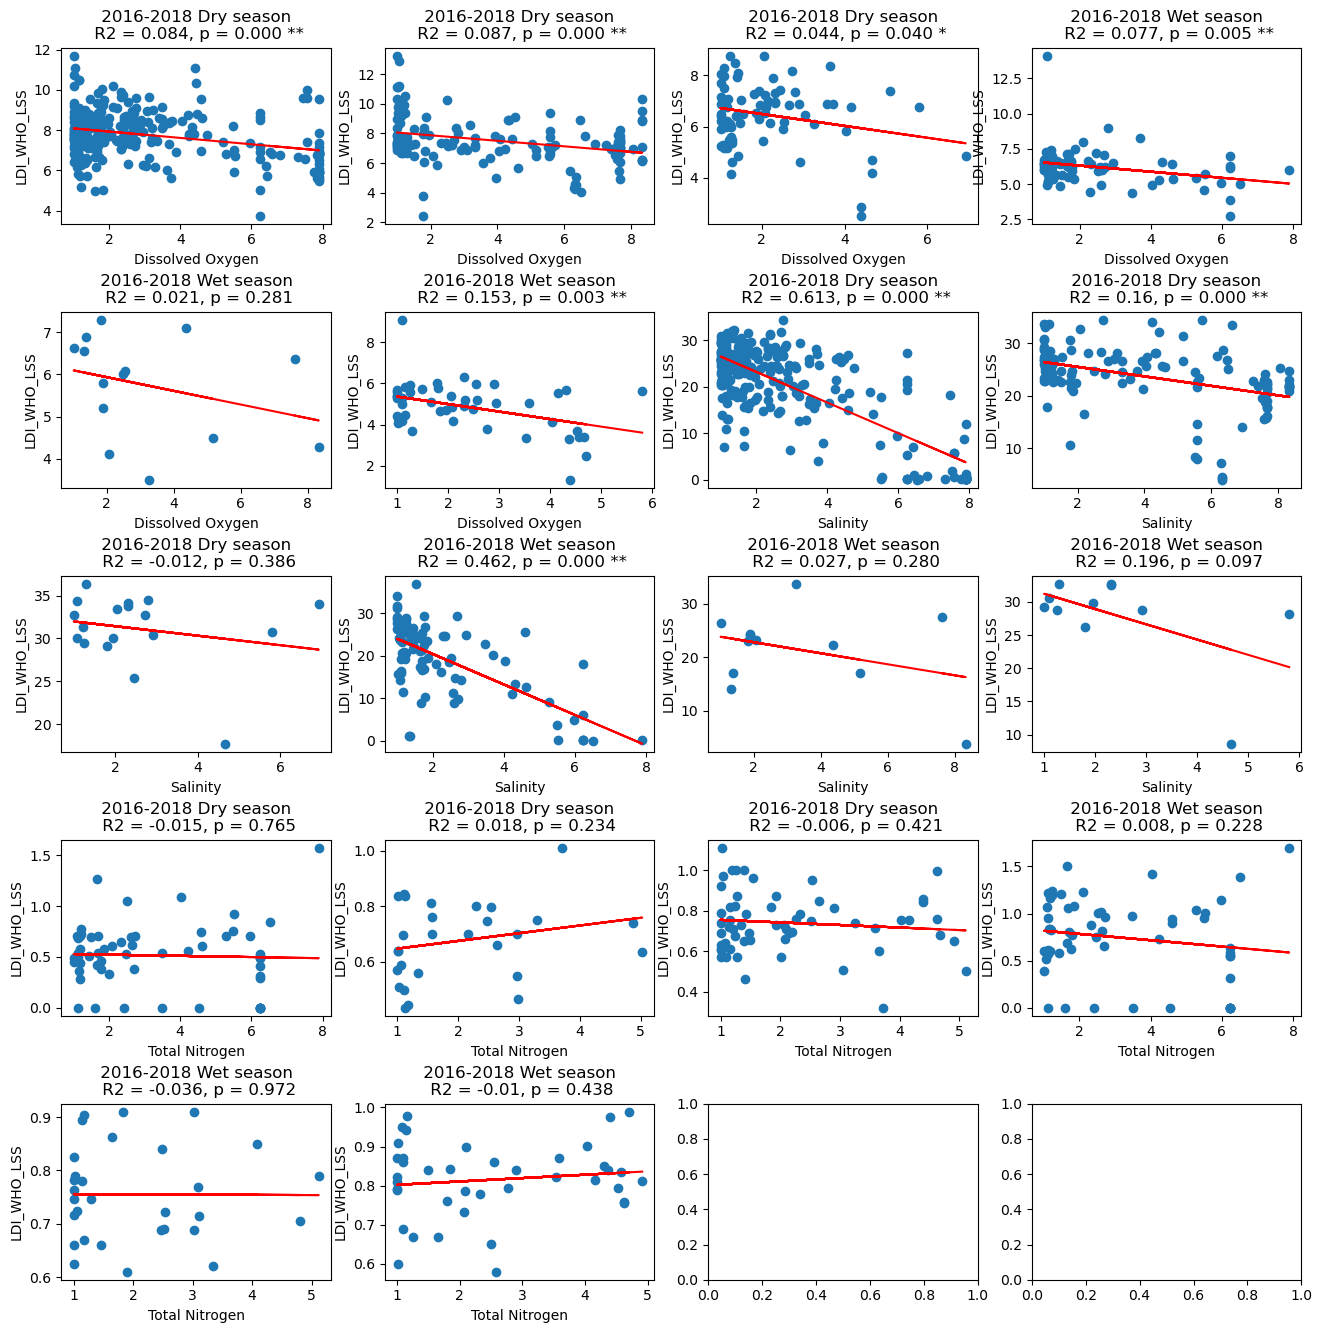

In [75]:
plot_regression(outputs_LDI_WHO_LSS)

### 3.1.5 Land development index (LDI_WHO_Median) <a class="anchor" id="result_cor_ldi_who_med"></a>

In [76]:
results_LDI_WHO_Median

,Dependent,Independent,Year,Season,Coefficient,Adjusted R-squared,p-value
0,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,0.463502,0.004702,0.116
1,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,-0.263511,0.068425,0.001 **
2,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Dry,-0.212220,0.058124,0.021 *
3,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.531181,0.003495,0.255
4,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.238982,-0.021136,0.409
5,Dissolved Oxygen,LDI_WHO_Median,2016-2018,Wet,-0.192625,0.046864,0.075
6,Salinity,LDI_WHO_Median,2016-2018,Dry,4.304145,0.007828,0.063
7,Salinity,LDI_WHO_Median,2016-2018,Dry,-0.015908,-0.008176,0.960
8,Salinity,LDI_WHO_Median,2016-2018,Dry,0.154547,-0.058562,0.810
9,Salinity,LDI_WHO_Median,2016-2018,Wet,4.928345,0.013788,0.132


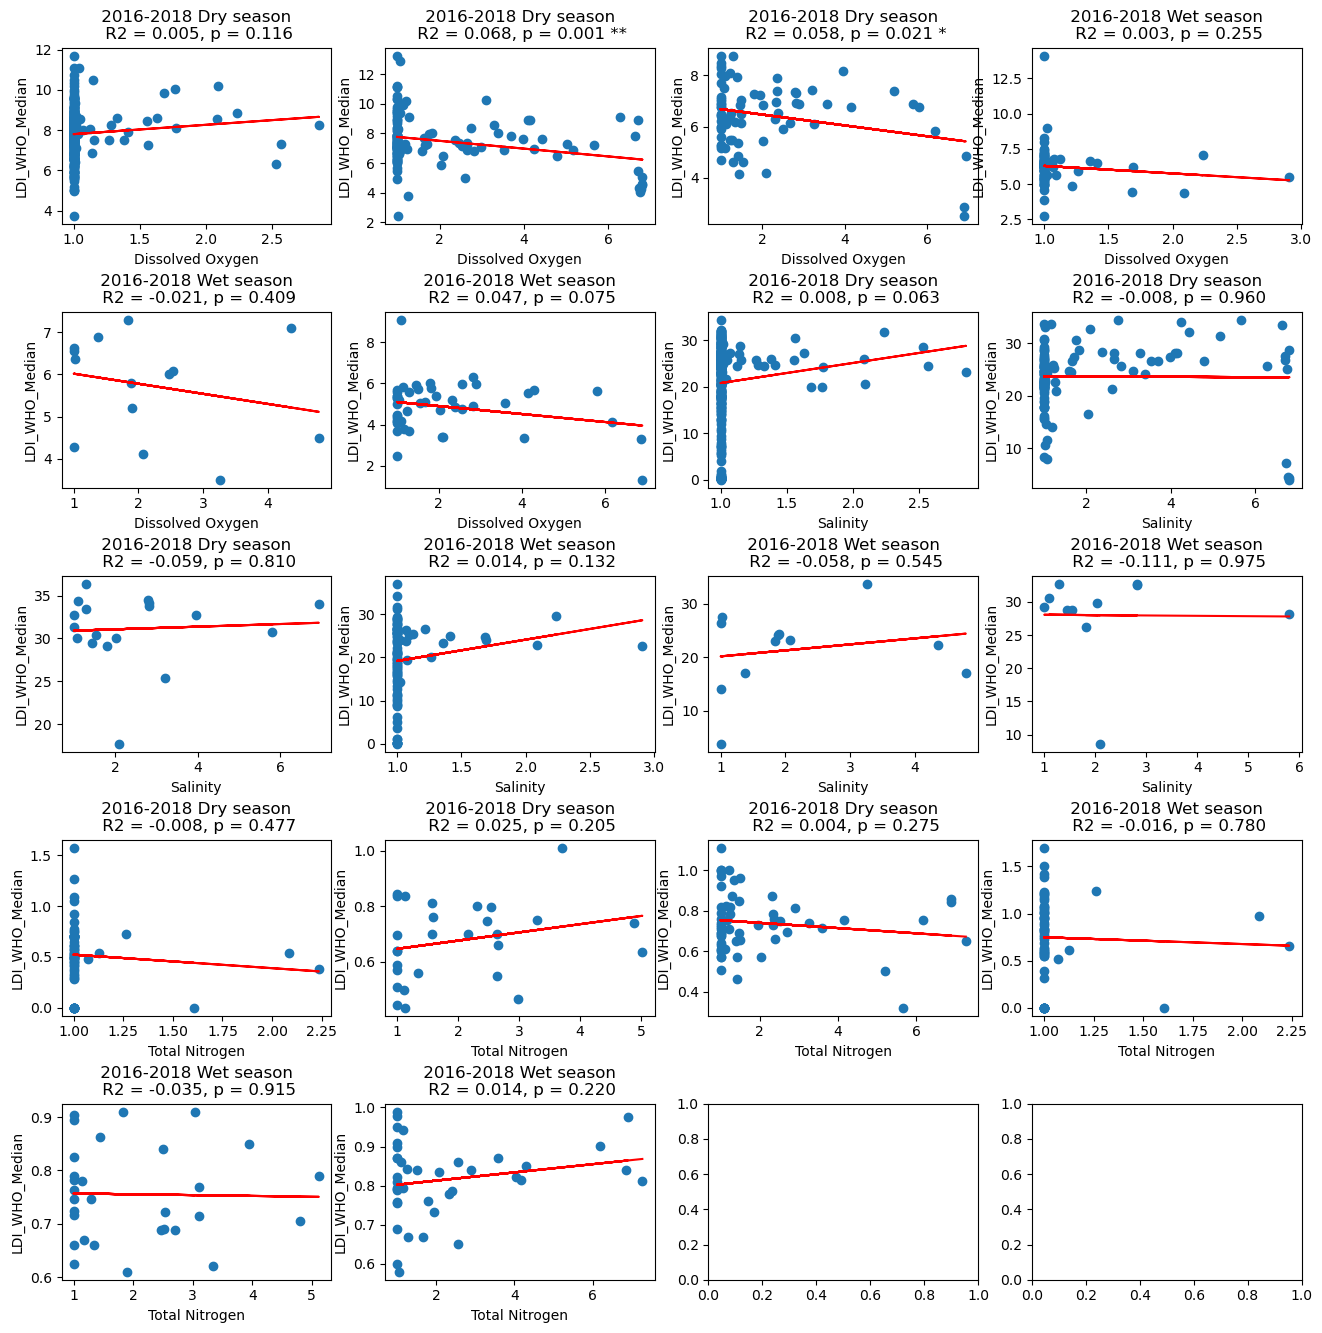

In [77]:
plot_regression(outputs_LDI_WHO_Median)